# Daniel S.

In [1]:
!pip install transformers
!pip install torch
!pip install --upgrade accelerate


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import re

def mergeIntervals(intervals):
    # Sort the array on the basis of start values of intervals.
    intervals.sort()
    stack = []
    # insert first interval into stack
    stack.append(intervals[0])
    for i in intervals[1:]:
        # Check for overlapping interval,
        # if interval overlap
        if stack[-1][0] <= i[0] <= stack[-1][-1]:
            stack[-1][-1] = max(stack[-1][-1], i[-1])
        else:
            stack.append(i)
    return stack


# Get all the file names that will be used to get the passages and corresponding labels.
def load_labeled_passages(set_type):
    train_files = os.listdir(f"/data/notebook_files/datasets/{set_type}-articles/")
    train_file_prefixes = [x.replace(".txt", "") for x in train_files]
    del train_files

    articles_with_labels = []
    for prefix in train_file_prefixes:
        article_data = {"article": "", "labels": [], "prefix": prefix}
        article_file_name = f"/data/notebook_files/datasets/{set_type}-articles/{prefix}.txt"
        labels_file_name = f"/data/notebook_files/datasets/{set_type}-labels-task-si/{prefix}.task-si.labels"

        with open(article_file_name, "r") as article_file:
            with open(labels_file_name, "r") as labels_file:
                article = article_file.read()
                article_data["article"] = article
                intervals = []
                for line in labels_file:
                    _, start, end = line.split()
                    intervals.append([int(start), int(end)])
                if len(intervals) != 0:
                    intervals = mergeIntervals(intervals)
                    article_data["labels"] = intervals
        articles_with_labels.append(article_data)

    return articles_with_labels

def insert_into_str(string, idx, value):
    return string[:idx] + value + string[idx:]

def tag_article(article, spans):
    spans.sort(key=lambda x: x[1], reverse=True)
    for s, e in spans:
        article = insert_into_str(article, e, "[END]")
        article = insert_into_str(article, s, "[START]")

    return article

def sentence_groups(articles):
    grouped_data = []
    for article in articles:
        group = {"title": None, "groups": [], "isFalse": []}
        text = article["article"]
        group["title"] = text.split("\n").pop(0)
        spans = article["labels"]
        text = tag_article(text, spans)
        sentences = text.split("\n")
        for i in range(len(sentences) - 1):
            sent1 = sentences[i]
            sent2 = sentences[i + 1]
            double_sentence = sent1 + sent2
            is_false = re.search(r"\[START\].*?\[END\]", double_sentence) is not None
            
            sent1 = sent1.replace("[START]", "")
            sent1 = sent1.replace("[END]", "")
            
            sent2 = sent2.replace("[START]", "")
            sent2 = sent2.replace("[END]", "")

            group["groups"].append((sent1, sent2))
            group["isFalse"].append(is_false)

        grouped_data.append(group)
    
    return grouped_data
            

In [3]:
import torch
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from itertools import permutations
from torch.utils.data import DataLoader

MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 32

class SentencePairsDataset(torch.utils.data.Dataset):
    def __init__(self, set_type, tokenizer):
        sentence_groups_list = sentence_groups(load_labeled_passages(set_type))
        self.title_sentences_pairs = []
        self.truthiness = []
        self.tokenizer = tokenizer

        for sentence_dict in sentence_groups_list:
            title = sentence_dict["title"]
            for truthiness, sentence in zip(sentence_dict["isFalse"], sentence_dict["groups"]):
                self.title_sentences_pairs.append((title, sentence))
                self.truthiness.append(truthiness)
    
    def __len__(self):
        return len(self.title_sentences_pairs)
    
    def __getitem__(self, idx):
        title, sentence_pair = self.title_sentences_pairs[idx]
        sent1, sent2 = sentence_pair
        label = self.truthiness[idx]
        input_string = f"[CLS]{title}[SEP]{sent1}[SEP]{sent2}"
        inputs = self.tokenizer(input_string, padding="max_length", truncation=True, return_tensors="pt")
        
        for k, v in inputs.items():
            inputs[k] = inputs[k].squeeze()
        
        inputs["labels"] = int(label)
        
        return inputs

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # We only need to classes (True / False)

# Set up the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    print("Looks like a GPU is not available.")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.

In [5]:
train_data = SentencePairsDataset("train", tokenizer)
dev_data = SentencePairsDataset("dev", tokenizer)

In [6]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metric(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, predictions)}

In [7]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="steps",
                                  num_train_epochs=3,
                                  fp16=True,
                                  eval_steps=700,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  do_eval=True
                                  )



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    compute_metrics=compute_metric
)

In [8]:
trainer.train()

/opt/python/envs/default/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1
700,0.496100,0.669091,0.660759
1400,0.296700,0.922548,0.671605


TrainOutput(global_step=1641, training_loss=0.3003787773546106, metrics={'train_runtime': 912.3054, 'train_samples_per_second': 57.494, 'train_steps_per_second': 1.799, 'total_flos': 6948179994304512.0, 'train_loss': 0.3003787773546106, 'epoch': 3.0})

In [9]:
trainer.evaluate(eval_dataset=dev_data)

[408/408 00:18]

{'eval_loss': 0.8782352209091187,
 'eval_f1': 0.6796347757046447,
 'eval_runtime': 18.2087,
 'eval_samples_per_second': 179.145,
 'eval_steps_per_second': 22.407,
 'epoch': 3.0}

In [10]:
trainer.save_model("/data/notebook_files/window_model")

# Scratch Area


In [52]:
from itertools import permutations

# This chunk is for checking if spans are overlapping.
# Conclusion: there are overlapping spans. Will be making sure to expand spans to their largest.
# This was fixed
for passage in passages:
    for span1, span2 in permutations(passage["labels"], 2):
        start1, end1 = span1
        start2, end2 = span2
        if (start1 <= end2 and start1 >= start2) or (end1 <= end2 and end1 >= start2):
            print(span1, span2)

In [53]:
# This chunk shows that some fallacies are spread over multiple sentences.
for passage in passages:
    article = passage["article"]
    longest = ""
    for start, end in passage["labels"]:
        if "." in article[start: end]:
            if len(article[start: end].split(".")) > len(longest):
                longest = article[start: end].split(".")
len(longest)

2

In [55]:
# Checking if some files don't have fallacies at all.
# Some files are completly free of fallacies.
for passage in passages:
    if len(passage["labels"]) == 0:
        print(passage)

{'article': "Ohio Cop Killing Suspect’s Wife Hid in Bushes While Husband Shot Officers, 911 Call Shows\n\nThe wife of the Ohio man suspected of killing two police officers on Saturday hid in the bushes as she called 911 to report that her husband had shot the cops, according to an audio recording of the call.\nWesterville Police Department officers Eric Joering, 39, and Anthony Morelli, 54, were allegedly shot dead by Quentin Smith after responding to a 911 hangup call.\nThe call, which prompted officers to respond to the scene, came in just around noon on Saturday.\nIn it, a woman can be heard crying before the line goes dead, the Cincinnati Enquirer reported.\nAfter dispatchers' attempts to return the call sent them to voicemail, Joering and Morelli went to the house, which had a history of domestic violence calls, according to the Columbus Dispatch.\nReuters Reuters\nIn the following call, the woman pleads for help.\n“Please help, please help,” she asks the dispatcher.\n“My husband 

In [22]:
len(train_data)

17484

In [11]:
good = 0
bad = 0
for item in train_data:
    if item["labels"] == 0:
        good += 1
    elif item["labels"] == 1:
        bad += 1

print(good)
print(bad)

10515
6969


In [12]:
good = 0
bad = 0
for item in dev_data:
    if item["labels"] == 0:
        good += 1
    elif item["labels"] == 1:
        bad += 1

print(good)
print(bad)

2079
1183


# Ritvik

In [49]:
!pip install transformers


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [50]:
import os
import re
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, TokenClassificationPipeline, EarlyStoppingCallback
import torch 
from torch.utils.data import DataLoader, TensorDataset

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
# Get all the file names that will be used to get the passages and corresponding labels.
def load_labeled_passages(set_type):
    train_files = os.listdir(f"/data/notebook_files/datasets/{set_type}-articles/")
    train_file_prefixes = [x.replace(".txt", "") for x in train_files]
    del train_files

    articles_with_labels = []
    for prefix in train_file_prefixes:
        # article_data = {"text": "", "labels": [], "prefix": prefix}
        article_data = {"text": "", "labels": []}
        article_file_name = f"/data/notebook_files/datasets/{set_type}-articles/{prefix}.txt"
        labels_file_name = f"/data/notebook_files/datasets/{set_type}-labels-task-flc-tc/{prefix}.task-flc-tc.labels"

        with open(article_file_name, "r") as article_file:
            with open(labels_file_name, "r") as labels_file:
                article = article_file.read()
                article_data["text"] = article
                intervals = []
                for line in labels_file:
                    _, technique, start, end = line.split()
                    intervals.append({"start": int(start), "end":int(end), "technique":technique})
                    article_data["labels"] = intervals
        articles_with_labels.append(article_data)

    return articles_with_labels

In [53]:
train_data = load_labeled_passages("train")
dev_data = load_labeled_passages("dev")
train_data

[{'text': 'Virginia man who wanted to join ISIS pleads guilty to lying about overseas trip\n\nNORFOLK, Va. — While texting with an FBI informant in September 2016, a Williamsburg man expressed admiration for a U.S. Army officer who shot and killed 13 soldiers on Fort Hood, Texas, according to court documents.\nLater that year, Shivam Patel, 28, tried to join the U.S. Army and Air Force.\nAnd in the application process, he lied to military recruiters about a recent trip he\'d taken to Jordan in a failed attempt to make contact with the Islamic State and join a "real Muslim Army," the documents said.\nPatel pleaded guilty Thursday in U.S. District Court to two counts of making false statements.\nHe faces up to 15 years in prison when sentenced June 4.\nAccording to court documents and prosecutors, Patel – who was raised Hindu before converting to Islam several years ago – traveled to China in July 2016 to teach English.\nWhile there, however, he grew displeased with how that country trea

In [54]:
#Tokenize the input using an autoencoder

# Load the ERNIE tokenizer
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-base-en")

# Tokenize the text and apply the labeling scheme
tokenized_texts_train = []
labels_train = []

for data in train_data:
    text = data['text']
    labels_example = []

    tokens = tokenizer.tokenize(text)
    for token in tokens:
        labels_token = "O"  # "O" for outside

        # Check if the token is part of a labeled text fragment
        for label in data['labels']:
            if token in tokenizer.tokenize(text[label['start']:label['end']]):
                labels_token = "B-" + label['technique']  # "B-" for beginning of a fragment

        labels_example.append(labels_token)
    
    tokenized_texts_train.append(tokens)
    labels_train.append(labels_example)

tokenized_texts_dev = []
labels_dev = []

for data in dev_data:
    text = data['text']
    labels_example = []

    tokens = tokenizer.tokenize(text)
    for token in tokens:
        labels_token = "O"  # "O" for outside

        # Check if the token is part of a labeled text fragment
        for label in data['labels']:
            if token in tokenizer.tokenize(text[label['start']:label['end']]):
                labels_token = "B-" + label['technique']  # "B-" for beginning of a fragment

        labels_example.append(labels_token)
    
    tokenized_texts_dev.append(tokens)
    labels_dev.append(labels_example)

KeyboardInterrupt: KeyboardInterrupt: 

In [48]:
# Convert text and labels to input features
input_ids_train = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts_train]
labels_train = [tokenizer.convert_tokens_to_ids(label) for label in labels_train]

input_ids_dev = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts_dev]
labels_dev = [tokenizer.convert_tokens_to_ids(label) for label in labels_dev]

# Create input tensors
input_ids_train = torch.tensor(input_ids_train)
labels_train = torch.tensor(labels_train)
input_ids_train = input_ids_train.to(device)
labels_train = labels_train.to(device)
input_ids_dev = torch.tensor(input_ids_dev)
labels_dev = torch.tensor(labels_dev)
input_ids_dev = input_ids_dev.to(device)
labels_dev = labels_dev.to(device)


# Create data loaders
dataset_train = TensorDataset(input_ids_train, labels_train)
loader_train = DataLoader(dataset_train, batch_size=32)

dataset_dev = TensorDataset(input_ids_dev, labels_dev)
loader_dev = DataLoader(dataset_dev, batch_size=32)

NameError: NameError: name 'device' is not defined

In [ ]:
# Load the ERNIE model for token classification
model = AutoModel.from_pretrained("nghuyong/ernie-2.0-base-en")
model = model.to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

In [ ]:
training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_steps=500,
    save_total_limit=5,
    evaluation_strategy="steps",
    eval_steps=500,
    push_to_hub=False,
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=100,
    do_train=True,
    do_eval=True,
    logging_first_step=True,
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.05)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=None,
    train_dataset=dataset_train,
    eval_dataset=dataset_dev,
    callbacks=[early_stopping]
)

trainer.train()

# Save the model
trainer.save_model("ernie_fallacy_detection_model")

# Ritvik-Big Bird

In [1]:
!pip install -U accelerate 
!pip install -U transformers
!pip install sentencepiece


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TokenClassificationPipeline, EarlyStoppingCallback
import torch
from torch.utils.data import DataLoader, TensorDataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
def split_techniques(data):
    result = []
    
    for item in data:
        techniques = item['technique'].split(',')
        for technique in techniques:
            result.append({
                'start': item['start'],
                'end': item['end'],
                'technique': technique.strip(),  # Remove leading/trailing spaces
            })

    return result

# Get all the file names that will be used to get the passages and corresponding labels.
def load_labeled_passages(set_type):
    train_files = os.listdir(f"/data/notebook_files/datasets/{set_type}-articles/")
    train_file_prefixes = [x.replace(".txt", "") for x in train_files]
    del train_files

    articles_with_labels = []
    for prefix in train_file_prefixes:
        # article_data = {"text": "", "labels": [], "prefix": prefix}
        article_data = {"text": "", "labels": []}
        article_file_name = f"/data/notebook_files/datasets/{set_type}-articles/{prefix}.txt"
        labels_file_name = f"/data/notebook_files/datasets/{set_type}-labels-task-flc-tc/{prefix}.task-flc-tc.labels"

        with open(article_file_name, "r") as article_file:
            with open(labels_file_name, "r") as labels_file:
                article = article_file.read()
                article_data["text"] = article
                intervals = []
                for line in labels_file:
                    _, technique, start, end = line.split()
                    intervals.append({"start": int(start), "end":int(end), "technique":technique})
                    article_data["labels"] = intervals
                article_data["labels"] = split_techniques(article_data["labels"])
        articles_with_labels.append(article_data)

    return articles_with_labels

In [5]:
train_data = load_labeled_passages("train")
dev_data = load_labeled_passages("dev")

In [6]:
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-roberta-base", use_fast=True)
label_map = {
    "0": 0,
    "Loaded_Language": 1,
    "Name_Calling": 2,
    "Labeling": 3,
    "Repetition": 4,
    "Exaggeration": 5,
    "Minimisation": 6,
    "Doubt": 7,
    "Appeal_to_fear-prejudice": 8,
    "Flag-Waving": 9,
    "Causal_Oversimplification": 10,
    "Slogans": 11,
    "Appeal_to_Authority": 12,
    "Black-and-White_Fallacy": 13,
    "Thought-terminating_Cliches": 14,
    "Whataboutism": 15,
    "Reductio_ad_hitlerum": 16,
    "Red_Herring": 17,
    "Bandwagon": 18,
    "Obfuscation": 19,
    "Intentional_Vagueness" :20,
    "Confusion": 21,
    "Straw_Men": 22
}
# Tokenize and apply the labeling scheme for both training and validation sets
tokenized_texts_train = []
labels_train = []

for data in train_data:
    text = data['text']
    labels_example = []

    tokens = tokenizer.tokenize(text, padding='max_length', max_length=2048, truncation=True, return_tensors='pt')
    for i, token in enumerate(tokens[0]):
        labels_token = []  # List to store all applicable labels

        # Check if the token is part of a labeled text fragment
        for label in data['labels']:
            if token in tokenizer.tokenize(text[label['start']:label['end']]):
                for token_label in label['technique'].split(','):
                    if token_label in label_map.keys():
                        labels_token.append(label_map[token_label])  # Add the technique to the list
                    else:
                        labels_token.append(label_map['0'])

        # If no labels are found for the token, assign the 'O' label
        if not labels_token:
            labels_token.append(label_map['0'])

        labels_example.append(labels_token)

    tokenized_texts_train.append(tokens)
    labels_train.append(labels_example)

# Similar modification for the validation data
tokenized_texts_dev = []
labels_dev = []

for data in dev_data:
    text = data['text']
    labels_example = []

    tokens = tokenizer.tokenize(text, padding='max_length', max_length=2048, truncation=True, return_tensors='pt')
    for i, token in enumerate(tokens[0]):
        labels_token = []  # List to store all applicable labels

        # Check if the token is part of a labeled text fragment
        for label in data['labels']:
            if token in tokenizer.tokenize(text[label['start']:label['end']]):
                for token_label in label['technique'].split(','):
                    if token_label in label_map.keys():
                        labels_token.append(label_map[token_label])  # Add the technique to the list
                    else:
                        labels_token.append(label_map['0'])

        # If no labels are found for the token, assign the 'O' label
        if not labels_token:
            labels_token.append(label_map['0'])

        labels_example.append(labels_token)

    tokenized_texts_dev.append(tokens)
    labels_dev.append(labels_example)

In [8]:
def tokenize_and_label(data, tokenizer, label_map, max_length=2048):
    tokens = tokenizer.encode_plus(data['text'], padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids'].to(device)

    labels_token = [0] * max_length  # Initialize all labels to 'O'

    # Iterate over each labeled text fragment
    for label in data['labels']:
        start_token = tokenizer.encode(data['text'][:label['start']], add_special_tokens=False)
        end_token = tokenizer.encode(data['text'][:label['end']], add_special_tokens=False)

        # Find the token positions corresponding to the start and end of the labeled fragment
        start_pos = len(start_token)
        end_pos = len(end_token)

        # Set labels for the labeled fragment to the corresponding values from label_map
        for i in range(min(end_pos, max_length)):
            labels_token[i] = label_map[label['technique']]

    # Truncate or pad labels and input_ids to max_length
    labels_token = labels_token[:max_length] + [0] * (max_length - len(labels_token))
    labels = torch.tensor(labels_token).unsqueeze(0).to(device)

    return input_ids, labels

# Tokenize and label training data
input_ids_train = []
labels_train = []

for data in train_data:
    input_ids, labels = tokenize_and_label(data, tokenizer, label_map, max_length=2048)
    
    # Check if the length of input_ids and labels is the same
    assert input_ids.size(1) == labels.size(1), "Size mismatch between input_ids and labels"
    
    input_ids_train.append(input_ids)
    labels_train.append(labels)

# Tokenize and label validation data
input_ids_dev = []
labels_dev = []

for data in dev_data:
    input_ids, labels = tokenize_and_label(data, tokenizer, label_map, max_length=2048)
    
    # Check if the length of input_ids and labels is the same
    assert input_ids.size(1) == labels.size(1), "Size mismatch between input_ids and labels"
    
    input_ids_dev.append(input_ids)
    labels_dev.append(labels)

train_dataset = DatasetDict({
    "input_ids": input_ids_train,
    "labels": labels_train,
})

dev_dataset = DatasetDict({
    "input_ids": input_ids_dev,
    "labels": labels_dev,
})

# Create data loaders
loader_train = DataLoader(train_dataset, batch_size=32)
loader_dev = DataLoader(dev_dataset, batch_size=32)


AssertionError: AssertionError: Size mismatch between tensors

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("google/bigbird-roberta-base", num_labels=23)
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

In [ ]:
training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=3,
    per_device_train_batch_size=2, 
    per_device_eval_batch_size=2,
    save_steps=500,
    save_total_limit=5,
    evaluation_strategy="steps",
    eval_steps=500,
    push_to_hub=False,
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=100,
    do_train=True,
    do_eval=True,
    logging_first_step=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=None,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)

trainer.train()
trainer.save_model("bigBird_fallacy_detection_model")

# Ritvik - Longformer

In [3]:
# !pip install -U accelerate
# !pip install -U transformers
# !pip install sentencepiece
# !pip install datasets

In [1]:
import os
import re
from transformers import LongformerTokenizer, TFLongformerForTokenClassification
import tensorflow as tf
from sklearn.metrics import f1_score

In [2]:
label_map = {
    "0": 0,
    "Loaded_Language": 1,
    "Name_Calling": 2,
    "Labeling": 3,
    "Repetition": 4,
    "Exaggeration": 5,
    "Minimisation": 6,
    "Doubt": 7,
    "Appeal_to_fear-prejudice": 8,
    "Flag-Waving": 9,
    "Causal_Oversimplification": 10,
    "Slogans": 11,
    "Appeal_to_Authority": 12,
    "Black-and-White_Fallacy": 13,
    "Thought-terminating_Cliches": 14,
    "Whataboutism": 15,
    "Reductio_ad_hitlerum": 16,
    "Red_Herring": 17,
    "Bandwagon": 18,
    "Obfuscation": 19,
    "Intentional_Vagueness" :20,
    "Confusion": 21,
    "Straw_Men": 22
}


# Get all the file names that will be used to get the passages and corresponding labels.
def load_labeled_passages(set_type):
    text = []
    labels = []
    text_fallacy = []

    train_files = os.listdir(f"/data/notebook_files/datasets/{set_type}-articles/")
    train_file_prefixes = [x.replace(".txt", "") for x in train_files]
    del train_files

    articles_with_labels = []
    for prefix in train_file_prefixes:
        article_file_name = f"/data/notebook_files/datasets/{set_type}-articles/{prefix}.txt"
        labels_file_name = f"/data/notebook_files/datasets/{set_type}-labels-task-flc-tc/{prefix}.task-flc-tc.labels"

        with open(article_file_name, "r") as article_file:
            with open(labels_file_name, "r") as labels_file:
                article = article_file.read()
                text.append(article)
                intervals = []
                text_label = [0]*23
                for line in labels_file:
                    _, technique, start, end = line.split()
                    for split_techniques in technique.split(','):
                        text_label[label_map[split_techniques]] = 1
                    intervals.append(article[int(start):int(end)])
                text_fallacy.append(intervals)
                labels.append(text_label)
                

    return {"text": text,
            "labels": labels,
            "text_fallacy": text_fallacy}

# Function to process long sequences
def process_long_sequences(text, fallacious_segments, max_length=2048):
    labels = [0] * max_length

    for segment in fallacious_segments:
        start = text.find(segment)
        end = start + len(segment)
        segment_ids = tokenizer.encode(text[:start], add_special_tokens=False)
        
        for i in range(start, min(end, max_length)):
            labels[i] = 1

    return labels

In [5]:
train_data = load_labeled_passages("train")

In [6]:
# Load Longformer tokenizer and model for token classification
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = TFLongformerForTokenClassification.from_pretrained('allenai/longformer-base-4096', num_labels=2)

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForTokenClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Tokenize and encode the text
train_input_ids = []
train_labels = []

for text, fallacious_segments in zip(train_data['text'], train_data['text_fallacy']):
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=2048, return_tensors='tf', return_token_type_ids=False)
    train_input_ids.append(encoding['input_ids'][0].numpy())
    
    labels = process_long_sequences(text, fallacious_segments)
    train_labels.append(labels)

train_input_ids = tf.convert_to_tensor(train_input_ids, dtype=tf.int32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)

Token indices sequence length is longer than the specified maximum sequence length for this model (4377 > 4096). Running this sequence through the model will result in indexing errors


In [4]:
# Train your model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_input_ids,
    train_labels,
    epochs=1,
    batch_size=1,
)

  3/371 [..............................] - ETA: 2:39:55 - loss: 4.2623 - accuracy: 0.6790

In [6]:
model.save_weights('/data/notebook_files/longformer_model.h5')

# Ritvik - LongformerTest

In [1]:
import os
import re
from transformers import LongformerTokenizer, TFLongformerForTokenClassification
import tensorflow as tf
from sklearn.metrics import f1_score

In [2]:
label_map = {
    "0": 0,
    "Loaded_Language": 1,
    "Name_Calling": 2,
    "Labeling": 3,
    "Repetition": 4,
    "Exaggeration": 5,
    "Minimisation": 6,
    "Doubt": 7,
    "Appeal_to_fear-prejudice": 8,
    "Flag-Waving": 9,
    "Causal_Oversimplification": 10,
    "Slogans": 11,
    "Appeal_to_Authority": 12,
    "Black-and-White_Fallacy": 13,
    "Thought-terminating_Cliches": 14,
    "Whataboutism": 15,
    "Reductio_ad_hitlerum": 16,
    "Red_Herring": 17,
    "Bandwagon": 18,
    "Obfuscation": 19,
    "Intentional_Vagueness" :20,
    "Confusion": 21,
    "Straw_Men": 22
}


# Get all the file names that will be used to get the passages and corresponding labels.
def load_labeled_passages(set_type):
    text = []
    labels = []
    text_fallacy = []

    train_files = os.listdir(f"datasets/{set_type}-articles/")
    train_file_prefixes = [x.replace(".txt", "") for x in train_files]
    del train_files

    articles_with_labels = []
    for prefix in train_file_prefixes:
        article_file_name = f"datasets/{set_type}-articles/{prefix}.txt"
        labels_file_name = f"datasets/{set_type}-labels-task-flc-tc/{prefix}.task-flc-tc.labels"

        with open(article_file_name, "r") as article_file:
            with open(labels_file_name, "r") as labels_file:
                article = article_file.read()
                text.append(article)
                intervals = []
                text_label = [0]*23
                for line in labels_file:
                    _, technique, start, end = line.split()
                    for split_techniques in technique.split(','):
                        text_label[label_map[split_techniques]] = 1
                    intervals.append(article[int(start):int(end)])
                text_fallacy.append(intervals)
                labels.append(text_label)


    return {"text": text,
            "labels": labels,
            "text_fallacy": text_fallacy}

# Function to process long sequences
def process_long_sequences(text, fallacious_segments, max_length=2048):
    labels = [0] * max_length

    for segment in fallacious_segments:
        start = text.find(segment)
        end = start + len(segment)
        segment_ids = tokenizer.encode(text[:start], add_special_tokens=False)

        for i in range(start, min(end, max_length)):
            labels[i] = 1

    return labels

In [3]:
dev_data = load_labeled_passages("dev")

In [5]:
# Load Longformer tokenizer and model for token classification
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Define your model architecture
model = TFLongformerForTokenClassification.from_pretrained('allenai/longformer-base-4096', num_labels=23)

# Load the trained weights
model.load_weights('/data/notebook_files/longformer_model.h5')

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForTokenClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'longformer_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Repeat the same process for the dev set
dev_input_ids = []
dev_labels = []

for text, fallacious_segments in zip(dev_data['text'], dev_data['text_fallacy']):
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=2048, return_tensors='tf', return_token_type_ids=False)
    dev_input_ids.append(encoding['input_ids'][0].numpy())
    
    labels = process_long_sequences(text, fallacious_segments)
    dev_labels.append(labels)

dev_input_ids = tf.convert_to_tensor(dev_input_ids, dtype=tf.int32)
dev_labels = tf.convert_to_tensor(dev_labels, dtype=tf.int32)

In [ ]:
# Evaluate your model with F1 score
dev_predictions = model.predict(dev_input_ids)
dev_predictions = tf.argmax(dev_predictions, axis=-1)

# Flatten the predictions and ground truth labels
dev_predictions_flat = tf.reshape(dev_predictions, [-1])
dev_labels_flat = tf.reshape(dev_labels, [-1])

# Calculate F1 score
f1 = f1_score(dev_labels_flat, dev_predictions_flat)

print(f"F1 Score: {f1}")

# Daniel P (Classification)

# Preprocessing
## Importations

In [1]:
!pip install transformers
!pip install torch
!pip install --upgrade accelerate
!pip install datasets
!pip install evaluate


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 39.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 21.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip ins

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, load_dataset, DatasetDict
import evaluate

## Import Data

In [3]:
# Get all the file names that will be used to get the passages and corresponding labels.
def create_label_df(set_type):
    fallacy_df = pd.read_csv(f"/data/notebook_files/datasets/{set_type}-task-flc-tc.labels",
                             sep="\t", header=None, names=["id", "label", "start", "end"])
    ids = list(set(fallacy_df["id"].to_list()))
    output_list = []
    for article_id in ids:
        f = open(f"/data/notebook_files/datasets/{set_type}-articles/article{article_id}.txt")
        context = f.read()
        subset_with_id = fallacy_df[fallacy_df["id"] == article_id].reset_index()
        for idx in range(subset_with_id.shape[0]):
            output_list.append([context[subset_with_id["start"][idx]:subset_with_id["end"][idx]], context, subset_with_id["label"][idx]])
    return_df = pd.DataFrame(output_list, columns=["span", "context", "fallacy"])
    return_df["span"] = return_df["span"].str.lower()
    return_df["context"] = return_df["context"].str.lower()
    return return_df

In [4]:
train = create_label_df("train")
# test = create_label_df("test") # Test requires submitting to outside thing
valid = create_label_df("dev")
train.head()

,span,context,fallacy
0,god damn america,conspiracy: muslim photographer & nation of is...,Slogans
1,"the terror group, the nation of islam",conspiracy: muslim photographer & nation of is...,"Bandwagon,Reductio_ad_hitlerum"
2,wicked deceivers,conspiracy: muslim photographer & nation of is...,Loaded_Language
3,sucked their blood,conspiracy: muslim photographer & nation of is...,Loaded_Language
4,people.\nyou have sucked their blood,conspiracy: muslim photographer & nation of is...,Thought-terminating_Cliches


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Slogans'),
  Text(1, 0, 'Bandwagon,Reductio_ad_hitlerum'),
  Text(2, 0, 'Loaded_Language'),
  Text(3, 0, 'Thought-terminating_Cliches'),
  Text(4, 0, 'Repetition'),
  Text(5, 0, 'Appeal_to_fear-prejudice'),
  Text(6, 0, 'Doubt'),
  Text(7, 0, 'Exaggeration,Minimisation'),
  Text(8, 0, 'Whataboutism,Straw_Men,Red_Herring'),
  Text(9, 0, 'Flag-Waving'),
  Text(10, 0, 'Name_Calling,Labeling'),
  Text(11, 0, 'Causal_Oversimplification'),
  Text(12, 0, 'Appeal_to_Authority'),
  Text(13, 0, 'Black-and-White_Fallacy')])

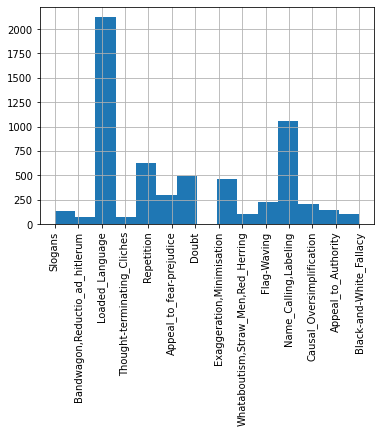

In [5]:
train["fallacy"].hist(bins=15)
plt.xticks(rotation=90)

In [6]:
labels = train["fallacy"].unique()
id2label = dict(zip(range(len(labels)), labels))
label2id = dict(zip(labels, range(len(labels))))
label2id

{'Slogans': 0,
 'Bandwagon,Reductio_ad_hitlerum': 1,
 'Loaded_Language': 2,
 'Thought-terminating_Cliches': 3,
 'Repetition': 4,
 'Appeal_to_fear-prejudice': 5,
 'Doubt': 6,
 'Exaggeration,Minimisation': 7,
 'Whataboutism,Straw_Men,Red_Herring': 8,
 'Flag-Waving': 9,
 'Name_Calling,Labeling': 10,
 'Causal_Oversimplification': 11,
 'Appeal_to_Authority': 12,
 'Black-and-White_Fallacy': 13}

In [8]:
train["labels"] = train["fallacy"].map(label2id)
valid["labels"] = valid["fallacy"].map(label2id)

## Dataframe -> Dataset

In [9]:
train_ds = Dataset.from_pandas(train)
valid_ds = Dataset.from_pandas(valid)
dsd = DatasetDict({
    "train": train_ds,
    "valid": valid_ds
})
dsd

DatasetDict({
    train: Dataset({
        features: ['span', 'context', 'fallacy', 'labels'],
        num_rows: 6128
    })
    valid: Dataset({
        features: ['span', 'context', 'fallacy', 'labels'],
        num_rows: 1063
    })
})

# Model Training

In [10]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=14)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

In [13]:
def tokenize(examples):
  return tokenizer(examples["span"], examples["context"], padding="max_length", truncation=True)
dsd_t = dsd.map(tokenize, batched=True)
dsd_t

DatasetDict({
    train: Dataset({
        features: ['span', 'context', 'fallacy', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6128
    })
    valid: Dataset({
        features: ['span', 'context', 'fallacy', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1063
    })
})

In [23]:
dsd_t['train']['attention_mask'].shape()

AttributeError: AttributeError: 'list' object has no attribute 'shape'

In [22]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metric(eval_pred):
    predictions = trainer.predict(dsd_t["eval"])
    pred = np.argmax(predictions.predictions, axis=-1)
    return {"f1": f1_score(y_true=pred, y_pred=predictions.label_ids, average="macro"), "accuracy": (pred == predictions.label_ids).mean()}

In [30]:
train_args = TrainingArguments(
    output_dir = "./tech_class",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    logging_steps=200
)
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=dsd_t["train"],
    eval_dataset=dsd_t["valid"],
    # compute_metrics=compute_metric
)
trainer.train()

Step,Training Loss
200,2.037500
400,1.526700
600,1.237100


TrainOutput(global_step=766, training_loss=1.5079209250507404, metrics={'train_runtime': 528.7349, 'train_samples_per_second': 23.18, 'train_steps_per_second': 1.449, 'total_flos': 1623867876114432.0, 'train_loss': 1.5079209250507404, 'epoch': 2.0})

# Test

In [13]:
accuracy = evaluate.load("accuracy")

In [33]:
def test_thingy(type_data):
    predictions = trainer.predict(dsd_t[type_data])
    pred = np.argmax(predictions.predictions, axis=-1)
    print(type_data)
    print(f1_score(y_true=pred, y_pred=predictions.label_ids, average="weighted"))
    print("accuracy:", (pred == predictions.label_ids).mean())

In [34]:
test_thingy("valid")

valid
0.5655126602683018
accuracy: 0.5014111006585137


In [35]:
test_thingy("train")

train
0.7485857320843269
accuracy: 0.706103133159269


# Daniel P (Correction)

# Preprocessing
## Importations

In [7]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Import

In [9]:
def create_label_df(set_type):
    fallacy_df = pd.read_csv(f"/data/notebook_files/datasets/{set_type}-task-flc-tc.labels",
                             sep="\t", header=None, names=["id", "label", "start", "end"])
    ids = list(set(fallacy_df["id"].to_list()))
    output_list = []
    for article_id in ids:
        f = open(f"/data/notebook_files/datasets/{set_type}-articles/article{article_id}.txt")
        context = f.read()
        subset_with_id = fallacy_df[fallacy_df["id"] == article_id].reset_index()
        for idx in range(subset_with_id.shape[0]):
            output_list.append([context[subset_with_id["start"][idx]:subset_with_id["end"][idx]], context, subset_with_id["label"][idx]])
    return_df = pd.DataFrame(output_list, columns=["span", "context", "fallacy"])
    return_df["span"] = return_df["span"].str.lower()
    return_df["context"] = return_df["context"].str.lower()
    return return_df
train = create_label_df("train")
train.head()

,span,context,fallacy
0,god damn america,conspiracy: muslim photographer & nation of is...,Slogans
1,"the terror group, the nation of islam",conspiracy: muslim photographer & nation of is...,"Bandwagon,Reductio_ad_hitlerum"
2,wicked deceivers,conspiracy: muslim photographer & nation of is...,Loaded_Language
3,sucked their blood,conspiracy: muslim photographer & nation of is...,Loaded_Language
4,people.\nyou have sucked their blood,conspiracy: muslim photographer & nation of is...,Thought-terminating_Cliches


In [10]:
train["context"][0]

"conspiracy: muslim photographer & nation of islam hid photos of obama with farrakhan since 2008\n\nthe left-wing enemedia worked as furiously to cover up, censor and sanction barack hussein obama’s jihad and violent left-wing connections as they do to manufacture and make up lies to destroy president trump.\nthe la times refused to release a video of the infamous jew-hating event obama hosted with close confidante and infamous antisemite rashid khalidi.\nthe media gave scant coverage to obama’s close relationship with radical reverend jeremiah “god damn america) wright who blamed the us for 9/11.\ni detailed obama’s nefarious connections and resulting worldview in my book, the post-american presidency: the obama administration’s war on america , which was ignored by the mainstream media.\nthe muslim photographer askia muhammad, who took this photo of candidate barack obama and vicious jihad-supporting racist louis farrakhan, knew this would impact the election: he said so.\nand so he 

# Pull out data
## Obtain one of each fallacy

In [39]:
fallacies = list(set(train["fallacy"].to_list()))
sample = pd.DataFrame(columns=train.columns)
for fallacy in fallacies:
    sample = pd.concat([sample, train[train["fallacy"] == fallacy].sample(random_state=420)])
sample

,span,context,fallacy
298,annihilated,muslim cleric: “there were jews in islamic cou...,Loaded_Language
1056,every one of us is born on death row and lives...,"the death penalty, instituted by god himself (...","Exaggeration,Minimisation"
3539,if you keep a handgun in the bedside table and...,has trump opened the door?\n\nsagacious gun ow...,Causal_Oversimplification
4142,"john hancock, the first signer of the declarat...",biblical illiterates reverse romans 13: teach ...,Appeal_to_Authority
1985,proving that the fbi specifically lied to the ...,confirmed: authorities lied about las vegas sh...,Repetition
3542,making his stupid stalinist statements about t...,has trump opened the door?\n\nsagacious gun ow...,"Bandwagon,Reductio_ad_hitlerum"
4437,righteous,sodom and gomorrah was judged by god because m...,"Name_Calling,Labeling"
5446,"but it is also about freedom of speech, about ...",the eerie silence\n\nin a recent communication...,Flag-Waving
4152,no enactment of man can be considered law unle...,biblical illiterates reverse romans 13: teach ...,Black-and-White_Fallacy
4218,garcia zarate’s background and nationality pla...,no justice for kate steinle\n\na san francisco...,Appeal_to_fear-prejudice


## Pulls out words on each side

In [41]:
def contains_span(span_words, context_words, start_idx):
    for i in range(len(span_words)):
        if span_words[i] not in context_words[start_idx + i]:
            return False
    return True

def search(span, context,n=10):
    span_words = span.split()
    context_words = context.split()

    for start_idx in range(len(context_words)):
        if span_words[0] in context_words[start_idx] and contains_span(span_words, context_words, start_idx):
            beginning = max(0, start_idx - n)
            ending = min(len(context_words), start_idx + len(span_words) + n)
            return_words = context_words[beginning:ending]
            return " ".join(return_words)


    return Exception("Not found")
print(search(train["span"][0], train["context"][0]))

scant coverage to obama’s close relationship with radical reverend jeremiah “god damn america) wright who blamed the us for 9/11. i detailed obama’s


In [42]:
sample["expanded_span"] = [search(*a) for a in tuple(zip(sample["span"], sample["context"]))]
sample_reset = sample.reset_index().drop(["index"], axis=1)
sample_reset[["fallacy", "span", "expanded_span"]]

,fallacy,span,expanded_span
0,Loaded_Language,annihilated,“tormenting and persecuting them.” “the jews w...
1,"Exaggeration,Minimisation",every one of us is born on death row and lives...,"the original sin, every living creature is sub..."
2,Causal_Oversimplification,if you keep a handgun in the bedside table and...,“reckless storage” of firearms and drinking ha...
3,Appeal_to_Authority,"john hancock, the first signer of the declarat...",moses and the children of israel safe on the s...
4,Repetition,proving that the fbi specifically lied to the ...,note that was reportedly written by an fbi age...
5,"Bandwagon,Reductio_ad_hitlerum",making his stupid stalinist statements about t...,"gun control, adding “mental health” restrictio..."
6,"Name_Calling,Labeling",righteous,hopes that god would have spared them rather t...
7,Flag-Waving,"but it is also about freedom of speech, about ...",the united states and ending up in a hell hole...
8,Black-and-White_Fallacy,no enactment of man can be considered law unle...,"law, the mosaic institution. read the 5 books ..."
9,Appeal_to_fear-prejudice,garcia zarate’s background and nationality pla...,"the trial, former vice presidential candidate ..."


# Ritvik - Roberta

In [ ]:
# Following this paper: https://arxiv.org/pdf/2008.02837.pdf
import os
import re
import pandas as pd
import torch
import torch.nn as nn
from torchcrf import CRF
from transformers import RobertaModel, RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text


# Get all the file names that will be used to get the passages and corresponding labels.
def load_labeled_passages(set_type):
    text = []
    bio_tagged = []
    labels = []

    train_files = os.listdir(f"datasets/{set_type}-articles/")
    train_file_prefixes = [x.replace(".txt", "") for x in train_files]
    del train_files

    articles_with_labels = []
    for prefix in train_file_prefixes:
        article_file_name = f"datasets/{set_type}-articles/{prefix}.txt"
        labels_file_name = f"datasets/{set_type}-labels-task-si/{prefix}.task-si.labels"

        with open(article_file_name, "r") as article_file:
            with open(labels_file_name, "r") as labels_file:
                article = article_file.read()
                bio_text = ['O']*len(article)
                text.append(preprocess_text(article))
                file_labels = []
                article_id_added = False
                for line in labels_file:
                    id, start, end = line.split()
                    found_tags = ['I-PROP'] * (int(end) - (int(start) + 1))
                    found_tags.insert(0, 'B-PROP')
                    bio_text[int(start):int(end)] = found_tags
                    file_labels.append(preprocess_text(article[int(start):int(end)]))
                labels.append(file_labels)
                bio_tagged.append(" ".join(bio_text))
    return {"text": text,
            "bio_tagged": bio_tagged,
            "labels": labels}

In [ ]:
train_data = load_labeled_passages("train")
dev_data = load_labeled_passages("dev")
df_train = pd.DataFrame(train_data)
df_dev = pd.DataFrame(dev_data)

In [ ]:
df_train.head()

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
label2idx = {'O': 0, 'B-PROP': 1, 'I-PROP': 2}

class CustomizedDataset(Dataset):
    def __init__(self, texts, bio_labels, tokenizer, max_length):
        self.texts = texts
        self.bio_labels = bio_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        bio_labels = self.bio_labels[idx].split()  # Split the string into a list of labels

        # Tokenize the text
        tokens = self.tokenizer.tokenize(text)

        # Create start_of_word_mask
        start_of_word_mask = [1 if token.startswith('##') else 0 for token in tokens]

        # Convert labels to indices (you may need to adapt this based on your specific labels)
        label_indices = [label2idx[label] for label in bio_labels]
        

        # Padding and truncation
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = input_ids[:self.max_length]
        start_of_word_mask = start_of_word_mask[:self.max_length]
        label_indices = label_indices[:self.max_length]

        # Padding
        padding_length = self.max_length - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        start_of_word_mask += [0] * padding_length
        label_indices += [0] * padding_length

        # Create attention_mask
        attention_mask = [1] * len(input_ids)

        return {
            'input_ids': torch.tensor(input_ids),
            'start_of_word_mask': torch.tensor(start_of_word_mask),
            'labels': torch.tensor(label_indices),
            'attention_mask': torch.tensor(attention_mask),
        }

In [ ]:
max_length = 128
batch_size = 16
train_dataset = CustomizedDataset(texts=df_train['text'], bio_labels=df_train['bio_tagged'], tokenizer=tokenizer, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomizedDataset(texts=df_dev['text'], bio_labels=df_dev['bio_tagged'], tokenizer=tokenizer, max_length=max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define a RoBERTa model with a CRF layer
class RoBERTaCRFModel(nn.Module):
    def __init__(self, num_labels, hidden_size=768):
        super(RoBERTaCRFModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.hidden_size = hidden_size
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        logits = outputs.last_hidden_state

        # Define the linear layer for classification
        linear_layer = nn.Linear(self.hidden_size, num_labels).to(device)
        logits = linear_layer(logits)

        if labels is not None:
            # Calculate the negative log likelihood for CRF
            loss = -model.crf(logits, labels, mask=attention_mask.byte(), reduction='mean')
            return loss
        else:
            # Use CRF to decode the best sequence
            best_paths = self.crf.decode(logits, mask=attention_mask.byte())
            return best_paths

In [ ]:
# Instantiate the model
num_labels = 3  
model = RoBERTaCRFModel(num_labels).to(device)

In [ ]:
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, labels)

        # Calculate the loss
        loss = outputs.mean()

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_batch in tqdm(val_loader, desc=f"Validation"):
            val_input_ids = val_batch['input_ids'].to(device)
            val_attention_mask = val_batch['attention_mask'].to(device)
            val_labels = val_batch['labels'].to(device)

            val_outputs = model(val_input_ids, val_attention_mask, val_labels)
            val_loss += val_outputs.mean().item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss}")

    # Adjust learning rate
    scheduler.step()

# Ritvik - BERT

In [ ]:
!pip install -U transformers
!pip install pytorch-crf

In [ ]:
import os
import re
import pandas as pd
import torch
import torch.nn as nn
from torchcrf import CRF
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report


from transformers import BertTokenizer, BertForTokenClassification, BertConfig
from torch.utils.data import Dataset, DataLoader
from torchcrf import CRF
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text


# Get all the file names that will be used to get the passages and corresponding labels.
def load_labeled_passages(set_type):
    text = []
    bio_tagged = []
    labels = []

    train_files = os.listdir(f"datasets/{set_type}-articles/")
    train_file_prefixes = [x.replace(".txt", "") for x in train_files]
    del train_files

    articles_with_labels = []
    for prefix in train_file_prefixes:
        article_file_name = f"datasets/{set_type}-articles/{prefix}.txt"
        labels_file_name = f"datasets/{set_type}-labels-task-si/{prefix}.task-si.labels"

        with open(article_file_name, "r") as article_file:
            with open(labels_file_name, "r") as labels_file:
                article = article_file.read()
                bio_text = ['O']*len(article)
                text.append(preprocess_text(article))
                file_labels = []
                article_id_added = False
                for line in labels_file:
                    id, start, end = line.split()
                    found_tags = ['I-PROP'] * (int(end) - (int(start) + 1))
                    found_tags.insert(0, 'B-PROP')
                    bio_text[int(start):int(end)] = found_tags
                    file_labels.append(preprocess_text(article[int(start):int(end)]))
                labels.append(file_labels)
                bio_tagged.append(" ".join(bio_text))
    return {"text": text,
            "bio_tagged": bio_tagged,
            "labels": labels}

In [ ]:
train_data = load_labeled_passages("train")
dev_data = load_labeled_passages("dev")
df_train = pd.DataFrame(train_data)
df_dev = pd.DataFrame(dev_data)

In [ ]:
df_train.head()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label2idx = {'O': 0, 'B-PROP': 1, 'I-PROP': 2}

class CustomizedDataset(Dataset):
    def __init__(self, texts, bio_labels, tokenizer, max_length):
        self.texts = texts
        self.bio_labels = bio_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        bio_labels = self.bio_labels[idx].split()  # Split the string into a list of labels

        # Tokenize the text
        tokens = self.tokenizer.tokenize(text)

        # Create start_of_word_mask
        start_of_word_mask = [1 if token.startswith('##') else 0 for token in tokens]

        # Convert labels to indices (you may need to adapt this based on your specific labels)
        label_indices = [label2idx[label] for label in bio_labels]
        

        # Padding and truncation
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = input_ids[:self.max_length]
        start_of_word_mask = start_of_word_mask[:self.max_length]
        label_indices = label_indices[:self.max_length]

        # Padding
        padding_length = self.max_length - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        start_of_word_mask += [0] * padding_length
        label_indices += [0] * padding_length

        # Create attention_mask
        attention_mask = [1] * len(input_ids)

        return {
            'input_ids': torch.tensor(input_ids),
            'start_of_word_mask': torch.tensor(start_of_word_mask),
            'labels': torch.tensor(label_indices),
            'attention_mask': torch.tensor(attention_mask),
        }

In [ ]:
max_length = 128
batch_size = 16
train_dataset = CustomizedDataset(texts=df_train['text'], bio_labels=df_train['bio_tagged'], tokenizer=tokenizer, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomizedDataset(texts=df_dev['text'], bio_labels=df_dev['bio_tagged'], tokenizer=tokenizer, max_length=max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label2idx)).to(device)
crf = CRF(num_tags=len(label2idx), batch_first=True)

In [ ]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # To accumulate the loss across batches

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Use outputs.loss instead of outputs.mean()

            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.update(1)  # Update tqdm progress bar
    avg_epoch_loss = epoch_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    true_labels = []
    predicted_labels = []

    with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                # Convert logits to predicted labels
                predicted_labels_batch = outputs.logits.argmax(dim=-1).cpu().numpy().flatten()
                true_labels_batch = labels.cpu().numpy().flatten()

                # Append batch-wise results to the overall lists
                predicted_labels.extend(predicted_labels_batch)
                true_labels.extend(true_labels_batch)

            val_loss += loss.item()
            pbar.update(1)

    # Calculate F1 score for each class
    f1_scores = f1_score(true_labels, predicted_labels, average=None)

    # Print F1 score for each class
    for i, f1 in enumerate(f1_scores):
        print(f"F1 Score for Class {i}: {f1:.4f}")

    # Calculate weighted or macro-average F1 score
    weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_epoch_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")

    # Update the learning rate based on the scheduler
    scheduler.step()

torch.save(model.state_dict(), 'propaganda_model.pth')